In [1]:
import os
TF_ENABLE_ONEDNN_OPTS=0
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from src.rozszerzanie import Rozszerzanie
from src.specaugment import SpecAugment
from src.funkcje import load_audio, mfcc, apply_spec_augment, plot_history, extract_mfcc
from sklearn.model_selection import train_test_split
print(np.__version__)

2.1.3


In [2]:
SR = 16000
DURATION = 1.0
POS_DIR = os.path.join('Nagrania', 'Hugo')
NEG_DIR = os.path.join('Nagrania', 'Negative')
OUTPUT_DIR = "processed_data"
seed = 42

In [3]:
augmenter = Rozszerzanie()
zmywanie = librosa.load(r'background\doing_the_dishes.wav', sr=SR)[0]
kran = librosa.load(r'background\running_tap.wav', sr=SR)[0]
rower = librosa.load(r'background\exercise_bike.wav', sr=SR)[0]

augmenter.add_noise_to_library('zmywanie', zmywanie)
augmenter.add_noise_to_library('rower', rower)
augmenter.add_noise_to_library('kran', kran)

In [4]:
def load_and_label():
    file_paths = []
    labels = []
    for file in os.listdir(POS_DIR):
        file_paths.append(os.path.join(POS_DIR, file))
        labels.append(1)
    for file in os.listdir(NEG_DIR):
        file_paths.append(os.path.join(NEG_DIR, file))
        labels.append(0)

    return file_paths, labels

In [5]:
def mfcc_normalization(mfccs):
    mean = tf.reduce_mean(mfccs, axis=1, keepdims=True)
    std = tf.math.reduce_std(mfccs, axis=1, keepdims=True)+1e-10
    return (mfccs - mean)/std

In [6]:
def process_data(file_paths, labels, augment=False):
    mfcc_features = []
    processed_labels = []
    n_mfcc = 20
    pos_aug_factor = 3
    neg_aug_factor = 0.1
    
    for path, label in zip(file_paths, labels):
        original_audio = load_audio(path, SR, DURATION)
        mfccs_orig = extract_mfcc(original_audio, sr=SR, n_mfcc=n_mfcc)

        mfcc_features.append(mfccs_orig)
        processed_labels.append(tf.constant(label, dtype=tf.int32))
        if augment:
            if label == 1:
                for _ in range(pos_aug_factor):
                    rand_val = random.random()

                    if rand_val < 0.4:
                        mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))

                    elif rand_val < 0.9:
                        current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.3, 'params': {'noise_factor': 0.03}},
                            {'name': 'time_stretch', 'p': 0.2, 'params': {'stretch_rate': random.uniform(0.93, 1.07), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.3, 'params': {'num_semitones': random.randint(-2, 2)}},
                            {'name': 'add_noise', 'p': 0.3, 'params': {
                                'noise_options': [["zmywanie", 0.4], ["kran", 0.3], ["rower", 0.3]],
                                'snr': random.randint(7, 20)}}]

                        augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.05)

                        mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))
            elif label == 0 and random.random() < neg_aug_factor:
                rand_val = random.random()
                if rand_val < 0.4:
                    mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

                elif rand_val < 0.9:
                    current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.4, 'params': {'noise_factor': 0.02}},
                            {'name': 'time_stretch', 'p': 0.4, 'params': {'stretch_rate': random.uniform(0.96, 1.03), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.2, 'params': {'num_semitones': random.randint(-1, 1)}}]

                    augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.01)
                    mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

    return mfcc_features, processed_labels

In [7]:
file_paths, labels = load_and_label()

In [8]:
print(file_paths[10], labels[10])

Nagrania\Hugo\hugo_108.wav 1


In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.3, stratify=labels, random_state=seed)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels = np.unique(train_labels)
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_labels  
)
# enumerate(weights) da (0, waga_dla_klasy_0), (1, waga_dla_klasy_1), itd.
class_weight_dict = dict(enumerate(weights))


In [11]:
X_train, y_train = process_data(train_paths, train_labels, augment=True)
X_test, y_test = process_data(test_paths, test_labels, augment=False)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=seed).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for x, y in train_dataset.take(10):
    print(x.shape)


(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)


In [ ]:
from keras.api import layers, models, activations, optimizers, regularizers, Input, utils, callbacks, losses, metrics
from models.models_wake_word import dscnn, crnn, resnet8, resnet14
input_shape = (X_train[0].shape[0], X_train[0].shape[1])


ValueError: Unrecognized keyword arguments passed to DepthwiseConv2D: {'kernel_regularizer': <keras.src.regularizers.regularizers.L2 object at 0x000002AEAC75F050>}

In [ ]:
model_resnet8 = resnet8(input_shape, num_classes=1, k=1.5)
model_resnet8.summary()
model_resnet14 = resnet14(input_shape, num_classes=1, k=1.5)
model_resnet14.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_30 (Conv1D)  │ (None, 98, 24)    │        480 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 49, 36)    │      2,592 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_31[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_28 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 49, 36)    │        864 │ conv1d_30[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_28[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_33[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_32[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_29 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_29[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_30 (ReLU)     │ (None, 49, 36)    │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_34 (Conv1D)  │ (None, 25, 48)    │      5,184 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_34[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_31 (ReLU)     │ (None, 25, 48)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 25, 48)    │      1,728 │ re_lu_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 25, 48)    │      6,912 │ re_lu_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_32 (ReLU)     │ (None, 25, 48)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 25, 48)    │          0 │ batch_normalizat

 Total params: 52,969 (206.91 KB)

 Trainable params: 52,033 (203.25 KB)

 Non-trainable params: 936 (3.66 KB)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 98, 24)    │      1,440 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 49, 36)    │      2,592 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 49, 36)    │        864 │ conv1d_40[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_37[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_42[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_38 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_12 (Add)        │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_38[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_39 (ReLU)     │ (None, 49, 36)    │          0 │ add_12[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_40 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_40[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_45[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_13 (Add)        │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_39[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_41 (ReLU)     │ (None, 49, 36)    │          0 │ add_13[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 25, 48)    │      5,184 │ re_lu_41[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_46[0][0] 

 Total params: 107,881 (421.41 KB)

 Trainable params: 106,321 (415.32 KB)

 Non-trainable params: 1,560 (6.09 KB)

Epoch 1/100
163/171 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - Precision: 0.5876 - Recall: 0.7362 - accuracy: 0.7655 - auc: 0.8362 - loss: 0.4570
Epoch 1: val_auc improved from -inf to 0.97561, saving model to trained_models_wake_word\resnet8_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - Precision: 0.5933 - Recall: 0.7393 - accuracy: 0.7698 - auc: 0.8404 - loss: 0.4507 - val_Precision: 0.7892 - val_Recall: 0.7529 - val_accuracy: 0.9547 - val_auc: 0.9756 - val_loss: 0.1732 - learning_rate: 5.0000e-04
Epoch 2/100
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - Precision: 0.8427 - Recall: 0.8596 - accuracy: 0.9162 - auc: 0.9664 - loss: 0.2129
Epoch 2: val_auc improved from 0.97561 to 0.98647, saving model to trained_models_wake_word\resnet8_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - Precision: 0.8427 - Recall: 0.8596 - accuracy: 0.9162 - auc: 0.9665 - loss: 0.2126 - val_Precision: 0.6445 - val_Recall: 0.9483 - val_accuracy: 0.9419 - val_auc: 0.9865 - val_loss: 0.1464 - lea

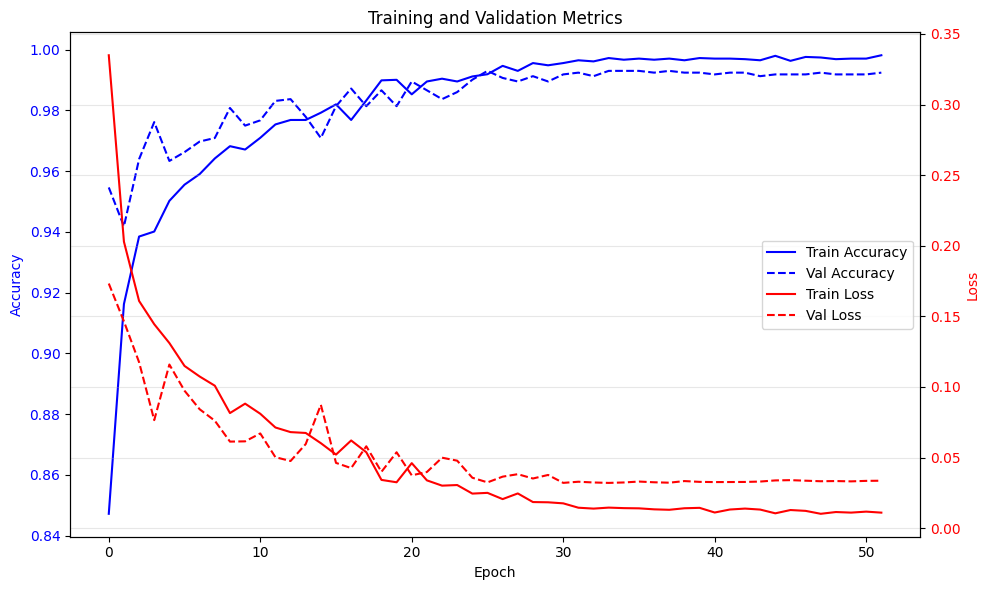

In [ ]:
model_resnet8.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet8_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet8_history = model_resnet8.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(resnet8_history)

Epoch 1/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.5813 - Recall: 0.7326 - accuracy: 0.7765 - auc: 0.8374 - loss: 0.4652
Epoch 1: val_auc improved from -inf to 0.95893, saving model to trained_models_wake_word\resnet14_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - Precision: 0.5833 - Recall: 0.7339 - accuracy: 0.7777 - auc: 0.8387 - loss: 0.4630 - val_Precision: 0.7073 - val_Recall: 0.6667 - val_accuracy: 0.9384 - val_auc: 0.9589 - val_loss: 0.1572 - learning_rate: 5.0000e-04
Epoch 2/100
166/171 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - Precision: 0.8393 - Recall: 0.8797 - accuracy: 0.9205 - auc: 0.9646 - loss: 0.2147
Epoch 2: val_auc improved from 0.95893 to 0.98851, saving model to trained_models_wake_word\resnet14_wake_word.keras
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - Precision: 0.8398 - Recall: 0.8802 - accuracy: 0.9208 - auc: 0.9649 - loss: 0.2138 - val_Precision: 0.7788 - val_Recall: 0.9310 - val_accuracy: 0.9663 - val_auc: 0.9885 - val_loss: 0.0887 -

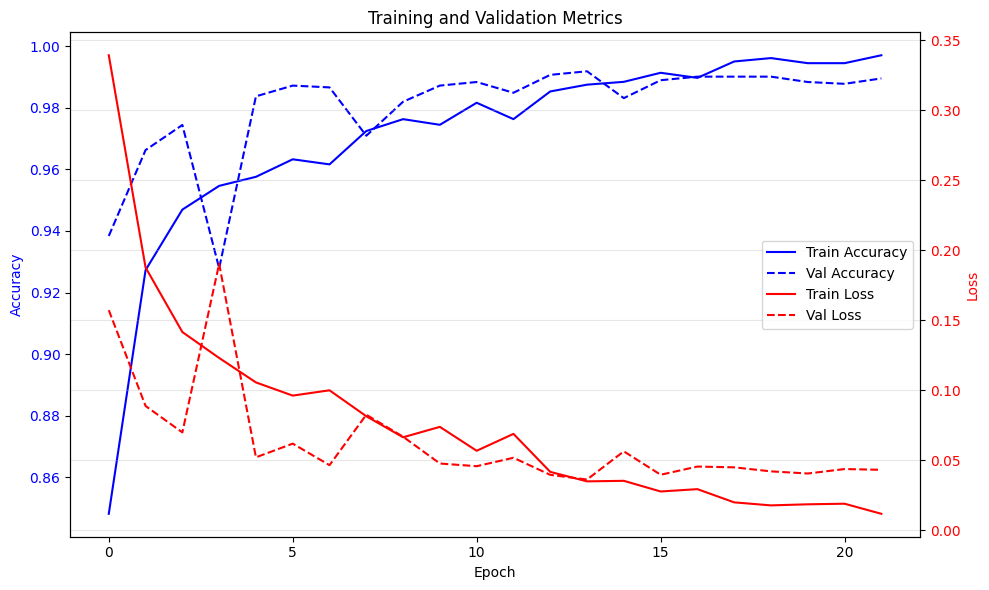

In [ ]:
model_resnet14.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet14_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet14_history = model_resnet14.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]    )
plot_history(resnet14_history)